# 用resnet-152训练cifar-10 ---FAIL!!!

失败原因推测：不会在加载本地数据和加载网络数据库中数据间转换

本地数据集的加载使用了imagefolder和dataloader,其中dataloader存在train和valid两种phase，在不同的phase下进行不同的操作；
而加载网络中的cifar-10数据库将分别得到train_loader和test_loader，
不会修改程序导致两段代码没能融合，无法运行。
即In[2]和In[13]中出现了冲突

本程序的目的：

在cifar-10数据集上，加载预训练的resnet-152，进行冻结，只对最后一个FC层进行修改和训练，观察实验结果

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms,models
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import torchvision
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

In [2]:
# 定义超参数 
input_size = 32  #输入图像的尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 2  #训练的总循环周期
batch_size = 64  #一个batch的大小为64张图片

# 加载训练集
train_dataset = datasets.CIFAR10(root='./data',  
                            train=True,   
                            transform=transforms.ToTensor(),  
                            download=True) 

# 加载测试集
test_dataset = datasets.CIFAR10(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 构建batch数据

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


In [3]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

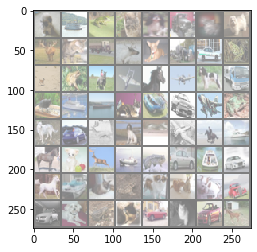

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图片的函数
def imshow(img):
    img = img / 2 + 0.5     # 非归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    # 随机获取训练集图片
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 展示图片
imshow(torchvision.utils.make_grid(images))


In [5]:
# 选择经典模型进行训练
model_name = 'resnet'  #可选 ['resnet', 'vgg']
#是否用人家训练好的特征来做，即使用别人已经训练好的权重，不做修改也不再进行训练
feature_extract = True 

In [6]:
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [7]:
# 写下把层的grad改为false的函数，使其无法训练，冻住
def set_parameter_requires_grad(model, feature_extracting):
    # 如果直接采用别人训练好的特征的话则把这个部分冻住，不可计算梯度使其无法训练
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 选择合适的模型，不同模型的初始化方法稍微有点区别
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        # 加载预训练后的resnet152
        model_ft = models.resnet152(pretrained=use_pretrained)
        # 指定部分层不做训练，被冻住
        set_parameter_requires_grad(model_ft, feature_extract)
        # 修改最后一层fc的输出参数为我们需要分辨的种类数10，损失函数用logsoftmax，不用交叉熵？？？？？？？？？？？？
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 10),
                                   nn.LogSoftmax(dim=1))
        input_size = 28

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 28

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [10]:
model_ft, input_size = initialize_model(model_name, 10, feature_extract, use_pretrained=True)

#GPU计算
model_ft = model_ft.to(device)

# 模型保存
filename='checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias


In [11]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [12]:
# 优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-3)
# 学习率衰减的设置，正常情况下使用较多，可使得结果更加稳定
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
#最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算了，nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合

#用于多分类的负对数似然损失函数（Negative Log Likelihood）,在前面接上一个 nn.LogSoftMax 层就等价于交叉熵损失了
criterion = nn.NLLLoss()

# criterion--损失函数
# optimizer--优化器


# 打印学习率
print('learning rate = ',optimizer_ft.param_groups[0]['lr'])


learning rate =  0.001


In [13]:
# is_inception--要不要用其他的网络
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,filename=filename):
    since = time.time()
    # 保存效果最好的模型
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device) # use gpu to train

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    # 储存最好的模型的权重参数
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+ 1, num_epochs))
        print('-' * 10)

       # for batch_idx, (data, target) in enumerate(train_loader):
        
        
            model_ft.train()  # 训练
           
            running_loss = 0.0
            running_corrects = 0

            # 取数据，分别按train和val来取
            for inputs, labels in train_loader:
                # 把取来的数据传入gpu进行训练
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                if torch.set_grad_enabled:
                    if is_inception:
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # 只有在训练阶段才能更新权重
                    
                    loss.backward()
                    optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) # 统计出预测对了多少个
                
                

            epoch_loss = running_loss / len(train_dataset)
            epoch_acc = running_corrects.double() / len(train_dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))
            
            
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 




optimizer_ft.param_groups[0]['lr']


IndentationError: unexpected indent (<ipython-input-13-e99e13b6ff9b>, line 31)

In [ ]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, train_loader, criterion, optimizer_ft, num_epochs=15, is_inception=(model_name=="inception"))

In[13]部分的原本代码：


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,filename=filename):
    since = time.time()
    # 保存效果最好的模型
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device) # use gpu to train

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    # 储存最好的模型的权重参数
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 取数据，分别按train和val来取
            for inputs, labels in dataloaders[phase]:
                # 把取来的数据传入gpu进行训练
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # 只有在训练阶段才能更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) # 统计出预测对了多少个

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(), #模型参数
                  'best_acc': best_acc, #最好优化效果
                  'optimizer' : optimizer.state_dict(), #优化器
                }
                # 在filename路径下保存当前state
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 